In [3]:
# EDA, preprocessing, and visualizing data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns

# Training model and evaluating performance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss, f1_score, precision_score, recall_score

# Alternative models to compare performance
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# User interface
import ipywidgets as widgets
from ipywidgets import Layout, Box, Label
from IPython.display import display
%matplotlib inline

In [4]:
# Load the Raw Data
df = pd.read_csv('../assets/dementia_patients_health_data.csv')

In [5]:
## Data Preprocessing

# Convert categorical features to numeric representation
categorical_features = ['Chronic_Health_Conditions', 'Smoking_Status', 'Family_History', 
                        'Education_Level', 'Dominant_Hand', 'Physical_Activity', 'Gender', 'Depression_Status']
processed_df = pd.get_dummies(df, columns=categorical_features, dtype=int)

# Create list of dummy categorical variables for user input dataframe
all_possible_dummies = [
    'Chronic_Health_Conditions_Diabetes', 'Chronic_Health_Conditions_Heart Disease', 'Chronic_Health_Conditions_Hypertension', 
    'Smoking_Status_Current Smoker', 'Smoking_Status_Former Smoker', 'Smoking_Status_Never Smoked',
    'Family_History_No', 'Family_History_Yes',
    'Education_Level_Diploma/Degree','Education_Level_No School', 'Education_Level_Primary School', 'Education_Level_Secondary School' 
    'Dominant_Hand_Left', 'Dominant_Hand_Right', 
    'Physical_Activity_Mild Activity', 'Physical_Activity_Moderate Activity', 'Physical_Activity_Sedentary'
    'Gender_Female', 'Gender_Male',
    'Depression_Status_No', 'Depression_Status_Yes'
]

# Rename original "Weight" feature to "Weight_In_Kilograms" for clarity
processed_df.rename(columns={'Weight':'Weight_In_Kilograms'}, inplace=True)

# Drop unused features (comments for each feature show reasoning)
unused_features = [
    'Diabetic', # Repeated in Chronic_Health_Conditions column
    'Prescription', # Correlated 100% with positive dementia diagnosis (overfit)
    'Dosage in mg', # Correlated 100% with positive dementia diagnosis (overfit)
    'APOE_ε4', # Removed to align with project goals of preventing additional testing beyond PCP
    'MRI_Delay', # Removed to align with project goals of preventing additional testing beyond PCP
    'AlcoholLevel', # Lack of clarity about what whe measurement means
    'Sleep_Quality', # Lack of contribution to prediction equation in feature importance analysis
    'Medication_History', # Lack of clarity about what whe measurement means
    'Cognitive_Test_Scores', # Removed to align with project goals of preventing additional testing beyond PCP
    'HeartRate', # Lack of contribution to prediction equation in feature importance analysis
    'Nutrition_Diet' # Lack of contribution to prediction equation in feature importance analysis
]
processed_df = processed_df.drop(columns=unused_features)


In [6]:
## Split Data

# Split independent and dependent data
X = processed_df.drop('Dementia', axis=1)
y = processed_df['Dementia']

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=23)

In [7]:
## Scale data to prevent skew of predictions due to differing units of measurement between features

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
## Train the model

# Logistic Regression
log_regression = LogisticRegression(random_state=25, solver='sag', max_iter=1000, class_weight='balanced', C=0.162378)
log_regression.fit(X_train, y_train)

# Make predictions
y_pred = log_regression.predict(X_train)

# Prediction probabilities
pred_probabilities = log_regression.predict_proba(X_train)

<Axes: ylabel='Feature'>

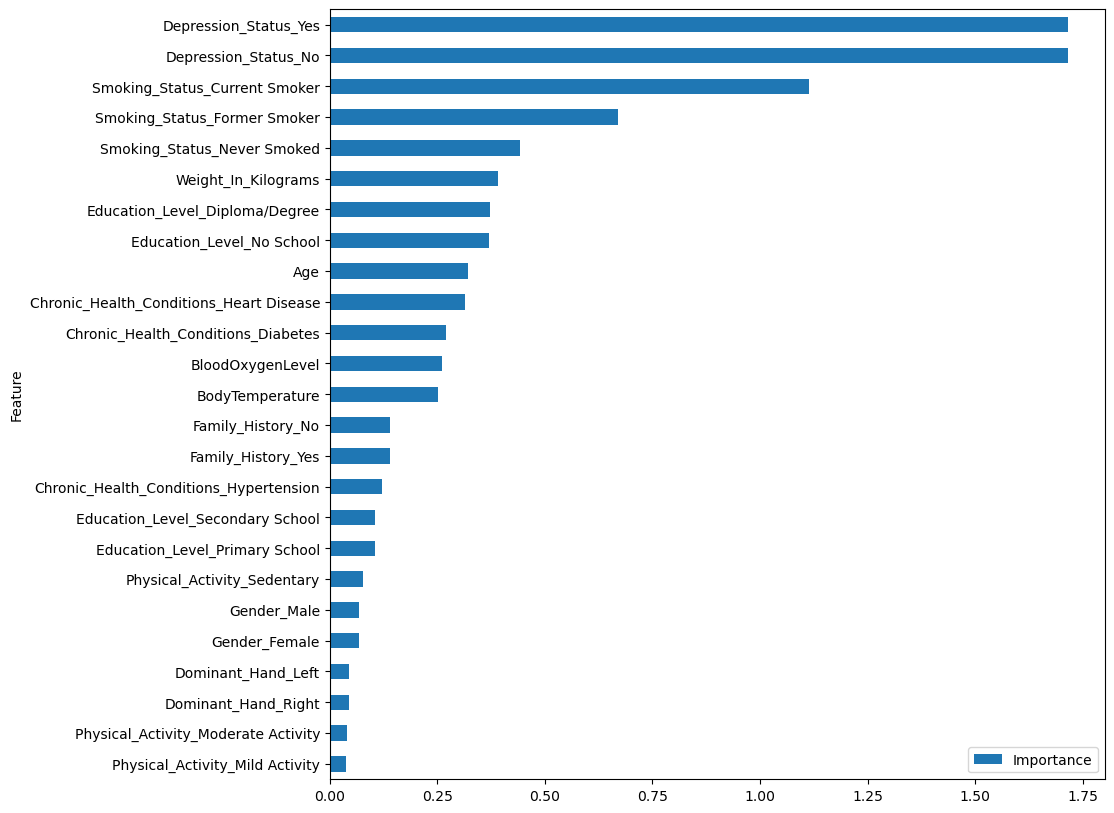

In [9]:
## Evaluate Feature Importance

coefficients = log_regression.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10,10))

In [10]:
## Evaluate Accuracy

# Accuracy on training data
print("The training accuracy is: ", log_regression.score(X_train, y_train))

# Accuracy on test data
print("The test accuracy is: ", log_regression.score(X_test, y_test))

# Classification Report
print(classification_report(y_train, y_pred))

The training accuracy is:  0.7775
The test accuracy is:  0.74
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       426
           1       0.90      0.59      0.71       374

    accuracy                           0.78       800
   macro avg       0.81      0.77      0.77       800
weighted avg       0.80      0.78      0.77       800



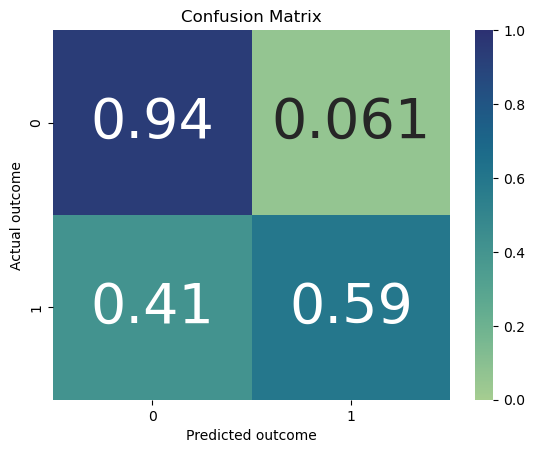

In [11]:
# Create confusion matrix
def plot_confusion_matrix(cm, classes = None, title = 'Confusion Matrix'):
    # Plots a confusion matrix
    if classes is not None:
        sns.heatmap(cm, xticklabels = classes, yticklabels = classes, vmin = 0., vmax = 1., cmap="crest", annot = True, annot_kws = {'size':40})
    else:
        sns.heatmap(cm, vmin = 0., vmax = 1.)
    plt.title(title)
    plt.ylabel('Actual outcome')
    plt.xlabel('Predicted outcome')

# Visualize confusion matrix
cm = confusion_matrix(y_train, y_pred)
cm_percentages = cm / cm.sum(axis = 1).reshape(-1, 1)
plot_confusion_matrix(cm_percentages, classes = log_regression.classes_, title = 'Confusion Matrix')

In [12]:
# Calculate false positives (FP), false negatives (FN), true positives (TP), and true negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is: ", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or false alarm rate
FPR = FP / (FP + TN)
print("The False Positive Rate is:", FPR)

# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is", FNR)

# Total averages
print()
print("The average TPR is:", TPR.sum()/2)
print("The average Precision is:", PPV.sum()/2)
print("The average FPR is:", FPR.sum()/2)
print("The average FNR is:", FNR.sum()/2)

# Log loss on training
print("The log loss on training data is: ", log_loss(y_train, pred_probabilities))

# Log loss on testing
pred_probabilities_test = log_regression.predict_proba(X_test)
print("The log loss on testing data is: ", log_loss(y_test, pred_probabilities_test))


The True Positive Rate is:  [0.93896714 0.59358289]
The Precision is: [0.72463768 0.89516129]
The False Positive Rate is: [0.40641711 0.06103286]
The False Negative Rate is [0.06103286 0.40641711]

The average TPR is: 0.7662750119253847
The average Precision is: 0.8098994857410005
The average FPR is: 0.23372498807461525
The average FNR is: 0.23372498807461525
The log loss on training data is:  0.4342983863963574
The log loss on testing data is:  0.4656859562005953


In [13]:
## Compare Model to Dummy Classifiers


# Train and compare dummy classifiers
dc = DummyClassifier(strategy='uniform')
dc.fit(X_train, y_train)
score = dc.score(X_test, y_test)

pred_probability_test = dc.predict_proba(X_test)
log_loss4 = log_loss(y_test, pred_probability_test)

print("(Uniform Strategy) Accuracy:", score)
print("(Uniform Strategy) Log Loss is:", log_loss4)

dc2 = DummyClassifier(strategy='most_frequent')
dc2.fit(X_train, y_train)
score2 = dc2.score(X_test, y_test)

pred_probability_test2 = dc2.predict_proba(X_test)
log_loss5 = log_loss(y_test, pred_probability_test2)

print("(Most Frequent Strategy) Accuracy:", score2)
print("(Most Frequent Strategy) Log Loss:", log_loss5)

(Uniform Strategy) Accuracy: 0.585
(Uniform Strategy) Log Loss is: 0.6931471805599452
(Most Frequent Strategy) Accuracy: 0.445
(Most Frequent Strategy) Log Loss: 20.004227630960017


In [14]:
## Test Alternative Models for Comparison

# List of models to test
models = {
    "Logistic Regression": LogisticRegression(random_state=23, solver='sag', max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=23),
    "Random Forest": RandomForestClassifier(random_state=23, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=23),
    "SVM": SVC(random_state=23, probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    return accuracy, f1, precision, recall

# Display confusion matrix for each model
def show_model_confusion_matrix(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_percentages = cm / cm.sum(axis = 1).reshape(-1, 1)
    plot_confusion_matrix(cm_percentages, classes = model.classes_, title = 'Confusion Matrix')
    plt.show()

# Evaluate all models
results = {}
for name, model in models.items():
    accuracy, f1, precision, recall = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}
    #print(f"{name}:")
    #show_model_confusion_matrix(model, X_train, y_train, X_test, y_test)

# Display results
for name, metrics in results.items():
    print(f"{name} - Accuracy: {metrics['Accuracy']:.4f}, F1 Score: {metrics['F1 Score']:.4f}, Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}")

results_df = pd.DataFrame(results).T
#print(results_df)

Logistic Regression - Accuracy: 0.7300, F1 Score: 0.7259, Precision: 0.7780, Recall: 0.7300
Decision Tree - Accuracy: 0.6850, F1 Score: 0.6857, Precision: 0.6963, Recall: 0.6850
Random Forest - Accuracy: 0.7200, F1 Score: 0.7131, Precision: 0.7830, Recall: 0.7200
Gradient Boosting - Accuracy: 0.7150, F1 Score: 0.7130, Precision: 0.7466, Recall: 0.7150
SVM - Accuracy: 0.7100, F1 Score: 0.6996, Precision: 0.7907, Recall: 0.7100
KNN - Accuracy: 0.6900, F1 Score: 0.6903, Precision: 0.7045, Recall: 0.6900
Naive Bayes - Accuracy: 0.7250, F1 Score: 0.7122, Precision: 0.8300, Recall: 0.7250


## Dementia Prediction App

In [15]:

# Title widget for UI tab
title = widgets.HTML(
            value="<h1>Patient Information</h1>"   
        )

# Create widgets for user input 
age = widgets.Text(value='0')
blood_oxygen = widgets.Text(value='0.0')
body_temperature = widgets.Text(value='0.0')
weight_in_lbs = widgets.Text(value='0.0')
chronic_health_conditions = widgets.Select(options=['Hypertension', 'Diabetes', 'Heart Disease'])

hypertension = widgets.Checkbox(
    value=False,
    description='Hypertension',
    disabled=False,
    indent=False
)

heart_disease = widgets.Checkbox(
    value=False,
    description='Heart Disease',
    disabled=False,
    indent=False
)

diabetes = widgets.Checkbox(
    value=False,
    description='Diabetes',
    disabled=False,
    indent=False
)

smoking_status = widgets.Select(options=['Current Smoker', 'Former Smoker', 'Never Smoked'])
education_level = widgets.Select(options=['Primary School', 'Secondary School', 'Diploma/Degree', 'No School'])
physical_activity_level = widgets.Select(options=['Sedentary', 'Mild Activity', 'Moderate Activity'])
dominant_hand = widgets.ToggleButtons(options=['Left', 'Right'])
gender = widgets.ToggleButtons(options=['Male', 'Female'])
family_history = widgets.ToggleButtons(options=['Yes', 'No'])
depression_status = widgets.ToggleButtons(options=['Yes', 'No'])


# Create widgets to make prediction and view results
predict_button = widgets.Button(description='Predict', disabled=False)
output = widgets.Output()


# Create layout for form items
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)

prediction_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='center'
)

form_items = [
    # Text input
    Box([title], layout=form_item_layout),
    Box([Label(value='Age:'), age], layout=form_item_layout),
    Box([Label(value='Blood Oxygen Level:'), blood_oxygen], layout=form_item_layout),
    Box([Label(value='Body Temperature:'), body_temperature], layout=form_item_layout),
    Box([Label(value='Weight(lbs):'), weight_in_lbs], layout=form_item_layout),

    # Selection boxes
    #Box([Label(value='Chronic health conditions:'), chronic_health_conditions], layout=form_item_layout),
    Box([Label(value='Smoking status:'), smoking_status], layout=form_item_layout),
    Box([Label(value='Highest education level completed:'), education_level], layout=form_item_layout),
    Box([Label(value='Physical activity level:'), physical_activity_level], layout=form_item_layout),

    # Check boxes
    Box([Label(value='Chronic health conditions:')], layout=form_item_layout),
    Box([hypertension], layout=prediction_layout),
    Box([heart_disease], layout=prediction_layout),
    Box([diabetes], layout=prediction_layout),

    # Toggle buttons
    Box([Label(value='Dominant hand:'), dominant_hand], layout=form_item_layout),
    Box([Label(value='Gender:'), gender], layout=form_item_layout),
    Box([Label(value='Family history of dementia:'), family_history], layout=form_item_layout),
    Box([Label(value='Diagnosed with depression:'), depression_status], layout=form_item_layout),

    # Predict Button
    Box([predict_button], layout=prediction_layout),

    
]    

        
# Test
# predict_button.on_click(predict_button_clicked, display(output))

# Function to convert categorical user input into form necessary to make prediction
def create_input_df():

    # Appropriate order of input for prediction:
    input_columns = ['BloodOxygenLevel', 'BodyTemperature', 'Weight_In_Kilograms', 'Age',
       'Chronic_Health_Conditions_Diabetes',
       'Chronic_Health_Conditions_Heart Disease',
       'Chronic_Health_Conditions_Hypertension',
       'Smoking_Status_Current Smoker', 'Smoking_Status_Former Smoker',
       'Smoking_Status_Never Smoked', 'Family_History_No',
       'Family_History_Yes', 'Education_Level_Diploma/Degree',
       'Education_Level_No School', 'Education_Level_Primary School',
       'Education_Level_Secondary School', 'Dominant_Hand_Left',
       'Dominant_Hand_Right', 'Physical_Activity_Mild Activity',
       'Physical_Activity_Moderate Activity', 'Physical_Activity_Sedentary',
       'Gender_Female', 'Gender_Male', 'Depression_Status_No',
       'Depression_Status_Yes']

    input_df = {column: 0.0 for column in input_columns}
    
    # Test case to validate user input prediction
    combined_user_input = {

    }

    # Convert to DataFrame
    input_df = pd.DataFrame(input_df, index=[0]) 

    return input_df

# Convert weight in lbs given to weight to kg (to be used as input for model)
def convert_lbs_to_kgs(pounds):
    return pounds * 0.453592

# Create layout for display of form
form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='55%',
    padding='20px'
))

# Display form
display(form, output)

# On click of the "Predict button":
def predict_button_clicked(b):
    with output:
        input_df = create_input_df()
        input_df['BloodOxygenLevel'] = blood_oxygen.value
        input_df['BodyTemperature'] = (float(body_temperature.value) - 32) * (5/9)
        input_df['Weight_In_Kilograms'] = convert_lbs_to_kgs(float(weight_in_lbs.value))
        input_df['Age'] = float(age.value)
    
        # Assign categorical values from user input to user input df
        if (hypertension.value):
            input_df[f'Chronic_Health_Conditions_{hypertension.description}'] = float(1)
        if (heart_disease.value):
            input_df[f'Chronic_Health_Conditions_{heart_disease.description}'] = float(1)
        if (diabetes.value):
            input_df[f'Chronic_Health_Conditions_{diabetes.description}'] = float(1)
        
        input_df[f'Smoking_Status_{smoking_status.value}'] = float(1)
        input_df[f'Education_Level_{education_level.value}'] = float(1)
        input_df[f'Physical_Activity_{physical_activity_level.value}'] = float(1)
        input_df[f'Dominant_Hand_{dominant_hand.value}'] = float(1)
        input_df[f'Gender_{gender.value}'] = float(1)
        input_df[f'Family_History_{family_history.value}'] = float(1)
        input_df[f'Depression_Status_{depression_status.value}'] = float(1)
    
        #input_df_normalized = scaler.transform(input_df)
        scaled_input_df = scaler.transform(input_df)
        prediction = log_regression.predict(scaled_input_df)
        prob = log_regression.predict_proba(scaled_input_df)
                
        dementia_risk = prediction
        print(f"Dementia prediction: {dementia_risk[0]}") #dementia_risk[0])
        #print(f"Probability ([Not having dementia, Having dementia]): {prob}")
        prob_rounded = round(prob[:,1][0], 2)
        print(f"Probability used to make classification: {prob_rounded}")
        print()

predict_button.on_click(predict_button_clicked)



Box(children=(Box(children=(HTML(value='<h1>Patient Information</h1>'),), layout=Layout(display='flex', flex_f…

Output()